In [1]:
import os
from pathlib import Path

root_folder = Path(os.getcwd())
dataset_dir = root_folder / "data/har-up-spiking-dataset-240"

batch_size = 1
nb_steps = 1500
max_length = 60.0
tau_mem = 100

[(4.757100e-03, 155, 133, 0) (4.757100e-03, 157, 146, 0)
 (4.757100e-03, 162, 143, 1) ... (9.147867e+00,  63, 104, 1)
 (9.147867e+00,  64,  83, 1) (9.158333e+00,  64,  83, 1)]


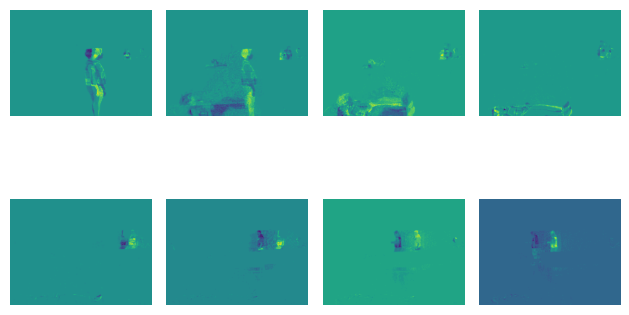

In [2]:
import tonic
from utils.SpikingDataset import SpikingDataset

dataset = SpikingDataset(
    root_dir=dataset_dir,
    time_duration=max_length,
    camera1_only=False,
)
train_dataset, dev_dataset, test_dataset = dataset.split_by_trials()

events, target = dataset[0]
print(events)
tonic.utils.plot_event_grid(events, axis_array=[2,4])


In [3]:
from utils.SpikingDataLoader import SpikingDataLoader

train_loader = SpikingDataLoader(dataset=train_dataset,nb_steps=nb_steps,batch_size=batch_size,shuffle=False)
dev_loader = SpikingDataLoader(dataset=dev_dataset, nb_steps=nb_steps, batch_size=batch_size, shuffle=False)
test_loader = SpikingDataLoader(dataset=test_dataset, nb_steps=nb_steps, batch_size=batch_size, shuffle=False)

Initializing DataLoader of size 10
Initializing DataLoader of size 2
Initializing DataLoader of size 4


In [4]:
from models.SNNTorchFC import SNNTorchFC

model = SNNTorchFC(
    num_inputs=dataset.nb_pixels,
    num_hidden=250,
    num_outputs=2,
    nb_steps=nb_steps,
    time_step=max_length / nb_steps,
    tau_mem=tau_mem * 1e-3,
)

LIF Parameter beta: 0.6703200460356393


In [5]:
from utils.Trainer import Trainer

trainer = Trainer(model=model)
trainer.train(
    train_loader,
    evaluate_dataloader=dev_loader,
    nb_epochs=20,
    stop_early=False,
    dataset_bias_ratio=10.0,
)

Epoch: 1
Dev Set Metrics : {'loss': 0.6631956994533539, 'accuracy': 0.95, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0}
Train Set Metrics : {'loss': 0.5098187655210495, 'accuracy': 0.955, 'precision': 0.3902439024390244, 'recall': 0.8888888888888888, 'f1_score': 0.5423728813559322}
Epoch 1 took 0 minutes 50 seconds
Epoch: 2
Dev Set Metrics : {'loss': 0.44010189175605774, 'accuracy': 0.9583333333333334, 'precision': 0.5555555555555556, 'recall': 0.8333333333333334, 'f1_score': 0.6666666666666666}
Train Set Metrics : {'loss': 0.38645188212394715, 'accuracy': 0.98, 'precision': 0.6, 'recall': 1.0, 'f1_score': 0.75}
Epoch 2 took 0 minutes 55 seconds
Epoch: 3
Dev Set Metrics : {'loss': 0.44887682795524597, 'accuracy': 0.975, 'precision': 0.7142857142857143, 'recall': 0.8333333333333334, 'f1_score': 0.7692307692307693}
Train Set Metrics : {'loss': 0.33440588414669037, 'accuracy': 0.9916666666666667, 'precision': 0.782608695652174, 'recall': 1.0, 'f1_score': 0.8780487804878049}
Epoch 3 to

In [7]:
import torch

model_name = "snntorch-fc"
model_save_file = root_folder / "models/saved"

torch.save(model.state_dict(), model_save_file / f"{model_name}.pt")

In [8]:
model = SNNTorchFC(
    num_inputs=dataset.nb_pixels,
    num_hidden=250,
    num_outputs=2,
    nb_steps=nb_steps,
    time_step=max_length / nb_steps,
    tau_mem=tau_mem * 1e-3,
)
model.load_state_dict(torch.load(model_save_file / f"{model_name}.pt", weights_only=True))

LIF Parameter beta: 0.6703200460356393


<All keys matched successfully>

In [10]:
with torch.inference_mode():
    for x_local, y_local in test_loader:

        x_local = x_local.to(model.device, model.dtype)
        y_local = y_local.to(model.device, model.dtype)

        mem_rec, spk_rec = model.forward(x_local.to_dense())
        break

mem_rec = mem_rec.cpu().detach().numpy()
spk_rec = spk_rec.cpu().detach().numpy()

In [ ]:
from utils.snntorch_visualizers import plot_cur_mem_spk



print(mem_rec.shape)
print(spk_rec.shape)
plot_cur_mem_spk(None, mem_rec[:, 0], spk_rec[:, 0], thr_line=1, ylim_max1=1.0,
                 title="snn.Leaky Neuron Model")

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'